# Free Lunch (there is such a thing!)
Working with NYC Department of Education (DOE) to develop a method to optimize school lunch and breakfast reimbursements from the federal and state government. 

## Overview
**Providing free universal lunch to all students**
The federal government offers meal subsidies to schools participating in the National School Lunch Program, run by the USDA. Traditionally this worked by giving a subsidy per meal based on the income level of the individual student's family. Because this leads to stigmatization of students from low income families, there has been a move towards more inclusive programs providing universal lunch to all students regardless of their family's income level. The Community Eligibility Provision (CEP) was created by the federal government in 2010. Under this program schools receive subsidies based on the overall makeup of the school (or group of schools). Participating schools are required to provide breakfast and lunch at no charge to all students. More information on NYC's initial involvement in CEP is available in a [Fiscal Brief](http://www.ibo.nyc.ny.us/iboreports/if-no-student-pays-cost-to-provide-free-lunch-for-all-of-new-york-citys-elementary-school-students.html) by the NYC Independent Budget Office.

We worked with NYC Department of Education to develope a method to optimize reimbursements.

## Reimbursement Rules:
Schools are reimbursed at either the "free" rate or the "paid" rate for each meal. (Traditionally there is also a "reduced" rate, but that does not apply here). The fraction of meals which are reimbursed at the "free" (this is the higher of the two rates) is determined by the group the school is enrolled under. This fraction we will call the $threshold$. The rest of the meals get reimbursed at the "paid" rate.

At a minimum, the paid rate, $r_{lunch/breakfast,paid}$, for all meals is subsidized. This includes total number of breakfasts for all schools $\sum_{s}B_s$, and total number of lunches for all schools $\sum_{s}L_s$. That means the base reimbursement, $R_{base}$, is independent of the groupings: 

$\begin{align}
R_{base} = r_{lunch,paid} \sum_{s}L_s + r_{breakfast,paid} \sum_{s}B_s
\end{align}$

So then total Reimbursement, $R$, is

$\begin{align}
R = \sum_{s} threshold_s (\Delta r_{lunch} L_s  + \Delta r_{breakfast} B_s) + R_{base}
\end{align}$

> where 
> $\begin{align}
&\Delta r_{breakfast} = r_{breakfast,free} - r_{breakfast,paid} \\
&\Delta r_{lunch} = r_{lunch,free} - r_{lunch,paid}
\end{align}$

> and the $threshold_s$ for each school, $s$, is determined it's group, $g$. It is the fraction of "identified students" $I_s$ for all schools in the group $g$ to the total number of "enrolled students" $N_s$ for all schools in the group, multiplied by a constant. This constant is set by the USDA at 1.6 but may change in subsequent years. $I_s$ and $N_s$ are based on enrollment in the previous school year. "Identified students" are those deemed categorically eligible for free meals, primarily due to receiving some sort of public assistance benefit.

> $\begin{align}
threshold_s =Min(1, \frac{ \sum_{s\in g} I_s} {\sum_{s\in g} N_s } * 1.6 )
\end{align}$

Before the school year begins, the groups are set and reported to the state. How schools should be grouped together is not prescribed. 

Reimbursements happen on a monthly basis after the school year begins and are determined the actual number of breakfasts and lunches eaten by the students. The groupings however, can only be based on projected meal counts.

## Grouping Rules
* All groups have to meet the minimum threshold: $threshold_{min} = 40\% * 1.6 = 64\%$
* There can be at most 9 (?) groups
* All schools must be part of the program

## Objective
Find the optimum groupings to maximize reimbursement, $R$.

## Challenge
For any given grouping, it is relatively easy to calculate the reimbursement. The problem is that the number of possible groupings quickly grows out of control.

In combinatorics, the number of ways to group a set of n objects into k (non-empty) groups is called the Stirling partition number, denoted by $S(n,k)$. For instance there are 3 ways to partition 3 items into 2 groups.

$\begin{align}
&S(3,2)=3\\
&S(10,4) = 34,105\\
&S(30,4) = 4.8 * 10^{16}\\
&S(100,4) = 6.7 * 10^{58}\\
\end{align}$

So with even just 100 schools and 4 groups brute forcing this calculation becomes impossible. To put it in perspective, even using the worlds fastest computers, assuming they can do quadrillions ($10^{15}$) of calculations per second, it would take more than the age of the universe to calculate reimbursements for 100 schools and all their possible groupings.

In [11]:
import pandas as pd
import numpy as np
import time
import multiprocessing as mp
import matplotlib.pyplot as plt
%matplotlib inline 
#plt.style.use('seaborn-poster')
#plt.style.use('fivethirtyeight')
import seaborn as sns
sns.set_context('poster',font_scale=1.2)

In [12]:
#constants
multiplier = 1.6

# combined Federal and NY State meal reimbursement rates
freeLunch = 3.2999
paidLunch = 0.4399
freeBreakfast = 2.1413
paidBreakfast = 0.2923

deltaLunchRate = freeLunch - paidLunch
deltaBreakfastRate = freeBreakfast - paidBreakfast 

t_min = 0.40 * multiplier

## Test data from DOE

In [13]:
# reading in data
doe = pd.read_excel('data/Test Data for CEP Grouping.xlsx',sheetname="School Data",header=2)
doe.rename(columns={'Identified Student Count':'Identified'},inplace=True)
print doe.shape
doe.head()

(1487, 5)


,School,Enrollment,Identified,Breakfast,Lunch
0,1019,268.0,114.0,13744.040323,32119.415317
1,1025,188.0,121.0,2660.633468,8954.467200
2,1034,348.0,262.0,18359.910484,39773.741129
3,1060,679.0,293.0,7340.885081,19996.654634
4,1061,291.0,99.0,4320.555242,25602.863216


### Data Dictionary
* School -  the school unique id
* Enrollment - the total number of students enrolled at the school
* Identified - the number of 'identified' students enrolled at the school. (should be less than Enrollment)
* Breakfast - the projected annual number of breakfasts served at the school.
* Lunch - the projected annual number of lunches served at the school


The Breakfast and Lunch columns are both pojected values by DOE. The actual numbers are not available until after the school year begins, after the groupings are already set.


### CEP dataframe

In [14]:
#some schools are listed as 0 enrollment, this is an artifact of how schools are counted. 
#keep only schools with >0 enrollment can be part of cep program.
cep = doe[doe.Enrollment>0].copy()
cep.reset_index(inplace=True)
print 'number of schools:',cep.shape[0]
print 'number of students:',round(cep.Enrollment.sum())
print 'number of identified students', round(cep.Identified.sum())
print 'overall identified student percentage', cep.Identified.sum()/cep.Enrollment.sum()

number of schools: 1453
number of students: 726514.0
number of identified students 329902.0
overall identified student percentage 0.454089403209


In [15]:
# define a few more columns that are useful.
# 'meal' is the max reimbursement of meals per year for each school.
# 'mealPerStudent' is the max per student.
# 'baseThreshold' is the threshold of the school if it is not grouped.
# 'group' will hold the integer name of the group the school belongs too. initally set a single group.

cep['meal'] = deltaLunchRate*cep['Lunch'] + deltaBreakfastRate*cep['Breakfast']
cep['paidMeal'] = paidLunch*cep['Lunch'] + paidBreakfast*cep['Breakfast']
cep['mealPerStudent'] = cep['meal']/cep['Enrollment']
cep['baseThreshold'] = cep['Identified']/cep['Enrollment']*multiplier
cep['group'] = 0

cep.head()

,index,School,Enrollment,Identified,Breakfast,Lunch,meal,paidMeal,mealPerStudent,baseThreshold,group
0,0,1019,268.0,114.0,13744.040323,32119.415317,117274.258362,18146.713784,437.590516,0.680597,0
1,1,1025,188.0,121.0,2660.633468,8954.467200,30529.287474,4716.773284,162.389827,1.029787,0
2,2,1034,348.0,262.0,18359.910484,39773.741129,147700.374114,22863.070557,424.426362,1.204598,0
3,3,1060,679.0,293.0,7340.885081,19996.654634,70763.728769,10942.269083,104.217568,0.690427,0
4,4,1061,291.0,99.0,4320.555242,25602.863216,81212.895439,12525.597826,279.082115,0.544330,0


## Calculating Reimbursements based on school groupings

In [16]:
# all meals in the CEP program are reimbursed at a minimum at the paid rate
baseReimburse = paidLunch*cep.Lunch.sum() + paidBreakfast*cep.Breakfast.sum()

# reimbursements over the base, this is the part that's dependant on groupings
def calcReimburse(cep,cost=0):
    ''' calculates and returns the total reimbursments (above base) for schools in a particlar grouping 
    Parameters:
    cep: dataframe where each row is a school. cep columns include: Identified, Enrollment, meal, group
    cost: cost = 0 (default) no cost to dropping schools from the program
          cost = 1 sets a high penalty for letting a group go below the min threshold'''
    
    group_cep = cep.groupby('group')
    df = pd.DataFrame(index= group_cep.indices) #each row represents a group

    df['threshold'] =  (group_cep['Identified'].sum()  / group_cep['Enrollment'].sum()) * multiplier
    df['meal']      =  group_cep['meal'].sum()
    
    # enforcing threshold rules:
    df['applied_threshold'] = df['threshold']
    df.loc[df['applied_threshold']  > 1, 'applied_threshold'] = 1
    df.loc[df['applied_threshold']  < t_min,'applied_threshold'] = 0 - cost*10**6

    df['reimbursed'] = df['applied_threshold'] * df['meal']
    
    return df.reimbursed.sum()

def setThreshold(cep):
    ''' calculates the threshold for each school based on its group
        cep columns: Enrollment, Identified'''
    for i in set(cep.group):
        df = cep[cep.group==i]
        cep.loc[cep.group == i,'threshold'] = df['Identified'].sum() / float(df['Enrollment'].sum()) * multiplier
    return 0

In [17]:
print ' base reimbursement (all schools reimbursed at paid rate):',"{:e}".format(baseReimburse)

print '\n if all schools were reimbursed at 100% threshold (all at free rate)\n\
then this is the additional reimbursment:','{:e}'.format(cep.meal.sum())
cep['group']=0
print '\n if all schools are put into a single group, \
the additional reimbursement (over base):','{:e}'.format(calcReimburse(cep))

 base reimbursement (all schools reimbursed at paid rate): 3.767395e+07

 if all schools were reimbursed at 100% threshold (all at free rate)
then this is the additional reimbursment: 2.434417e+08

 if all schools are put into a single group, the additional reimbursement (over base): 1.768709e+08


## Finding Maximum Reimbursements

Monte Carlo Methods - 1) stochastic hill climbing and 2) simulated annealing

The Metropolis-Hastings Monte Carlo method is a well known approach used to simulate complex, multi-dimensional probabilities where direct sampling is not feasible. For our purposes we are not interested in generating a probability distribution, but in finding the maximum value (or the highest reimbursement). So we we use two related methods: stochastic hill climbing and simulated annealing.

We set up a random walk where each new step is only based on the previous step and not the steps before that, i.e. it's "memoryless". (This is also sometimes called a Markov Chain). 

For our case a "step" is randomly choosing a school and moving it to another group. If the resulting step is "better" (has higher reimbursement) than the previous, then the step is accepted. If not, the step is rejected, meaning you throw it out and start back at the previous position. Many steps are then looped over until the result converges. This is stochastic hill climbing. 

Simulated annealing (code below) is similar but is more permissive in keeping steps that would otherwise be rejected. The idea is that allowing some of these to go through may give more flexibility in finding a global maximum. This method is modeled on physical processes where slowly lowering the temperature allows for the system to find the lowest energy state. For this we invent a temperature parameter and lower it by some delta until we get close to 0 (at which point it is the same as stochastic hill climbing). 

In practice the two methods yielded very similar results, but with simulated annealing getting there slightly faster.

1. Initialize: start in a random state, randomly group the schools, or with all schools in one group
2. Potential new step: choose a random school and change its group to another random group.
3. Compare: calculate the difference in reimbursements $\Delta R$
4. Accept/Reject Step: 
    - If the new reimbursement is greater than the old, $\Delta R >0$, then accept the new state
    - If the new reimbursement is less than the old,$\Delta R<0$, then accept with probability $e^{\Delta R/T}$
    - Otherwise reject.
5. Repeat from step 2 until the result converges, meaning all subsequent steps are rejected.



In [18]:
def simulated_annealing(cep, randomstart=True, seed=None,
                        ngroupstart=1,ngroups=10, Tmax=1, deltaT=0.1):
    '''simulated annealing procedure - finding optimal grouping
    cep: schools dataframe
    randomstart: if False start with groups already set in group column, otherwise
                 if True (default) start by randomly assigning groups 
    seed: seed for random generator
    ngroupstart: integer number of groups in the random start
    ngroups: number of groups
    Tmax: max value for "temperature"
    deltaT: change in "temperature" at each step
    
    returns a list of reimbursements at each step and the dataframe with the final groupings
    '''
    
    startTime = time.time()
    cep.reset_index(drop=True,inplace=True) 
    rows=cep.shape[0]

    # start by grouping schools randomly
    if randomstart:
        np.random.seed(seed)
        cep.loc[:,'group'] = pd.Series(np.random.randint(0,ngroupstart,size=rows),
                                       index=cep.index)

    # store the results
    old = calcReimburse(cep)
    results=[old]

    # mc loop
    for T in np.arange(Tmax,0,-deltaT):
        for i in range(1000):
            df = cep.copy()
            
            # choose a random school and move it to a different random group
            df.loc[np.random.randint(0,rows),'group'] = np.random.randint(0,ngroups)
                                                                                   
            # calculate the reimbursement
            new = calcReimburse(df,cost=1)
            step = new - old                                                                           
            
            #keep move if reimbursement increases
            if (step > 0):
                old=new
                cep.loc[:,'group'] = df.group
                results.append(new)
                
            #maybe keep move if reimbursement decreases, depending on how much
            elif (np.random.uniform() < np.exp(step/T)):
                old=new
                cep.loc[:,'group'] = df.group
                results.append(new)

    cep = regroup(cep) #combining groups close by
    final = calcReimburse(cep)
    results.append(final)
    print final
    print 'time in h', (time.time()-startTime)/60.0/60.0
    return results,cep


def regroup(cep):
    '''if cep has multiple thresholds within one percent of each other, this 
    combines them'''
    setThreshold(cep)
    tlist = cep.groupby(cep.threshold.apply(lambda x: round(x,2))).groups.keys()
    for i,t in enumerate(tlist):
        cep.loc[cep.threshold.apply(lambda x:round(x,2))==t,'group']=i
    setThreshold(cep)
    return cep

def sa_ensemble(cep,trials=10,randomstart=True,ngroupstart=1,ngroups=10,Tmax=1,deltaT=.1):
    '''run simulated annealing a number of times (trials) and choose the best 
    (highest reimbursement) as the final'''
    pool = mp.Pool(processes=4) # parrallel over 4 cores
    results = [pool.apply_async(simulated_annealing,
                                args=(cep,)) for x in range(trials)]
    results = [p.get() for p in results]
    
    reimb_ensemble = [results[i][0][-1] for i in range(trials)]
    cep_ensemble = [results[i][1] for i in range(trials)]
    
    max_reimb = max(reimb_ensemble)
    max_index = reimb_ensemble.index(max_reimb)

    return cep_ensemble[max_index]



## simulated annealing run and output

In [19]:
reimb, cep = simulated_annealing(cep, Tmax=1,deltaT=.01)
setThreshold(cep)

188124214.9
time in h 0.152015926639


0

Plotting out the reimbursement result at each step allows us to see if the run converged.

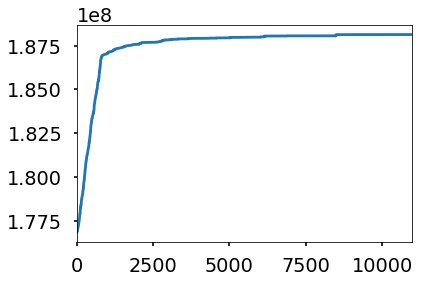

In [20]:
pd.Series(reimb).plot()

baseThreshold is the threshold the school would have if it's in it's own group. Its' the percentage of identified students in the school multiplied by 1.6. The y-axis is the final threshold for the school after it's in it's optimized group.

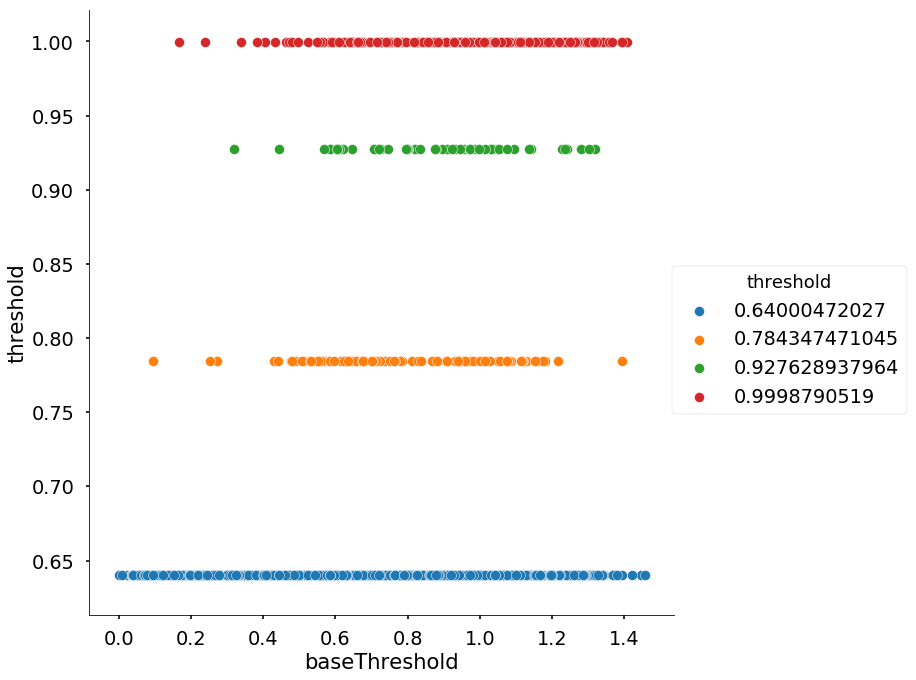

In [21]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['threshold'],data=cep, hue='threshold',
             size=10,plot_kws={'s':100})

In the graph below, each point is a school, the color represents its optimal group. The baseThreshold is the school's percent identified students times the multiplier 1.6. The mealPerStudent is the average reimbursement of the meal if it received full reimbursement (minus the lowest reimbursement cost).

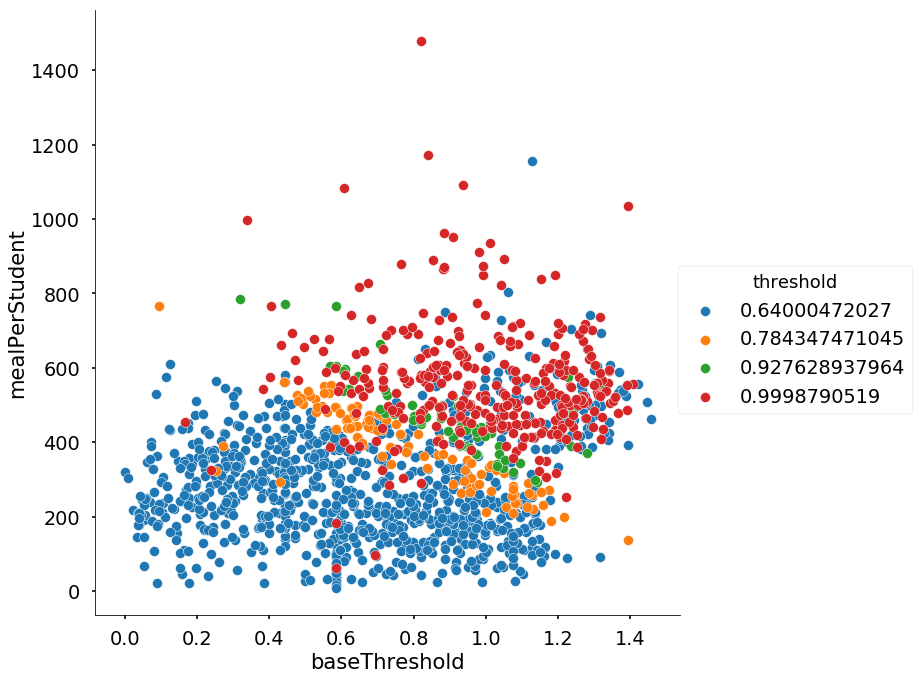

In [22]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cep, hue='threshold',
             size=10,plot_kws={'s':100})

In [23]:
pd.concat([cep.groupby('threshold').count()[['School']],
           cep.groupby('threshold').sum()[['Enrollment']],
           cep.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.640005,953,522041.524585,275.475036
0.784347,105,40838.872093,387.567172
0.927629,61,26449.991805,470.895394
0.999879,334,137183.577519,559.242409


## ensemble

Can we do any better? This is a stochastic method, meaning each time you restart you will get a slightly different answer. We can do this many times, utilizing python's parrallel processing capabilities, and choose the best of the lot.


In [28]:
%%capture
cep = sa_ensemble(cep,trials=100,Tmax=1,deltaT=.01)

In [29]:
calcReimburse(cep)

188225205.20846641

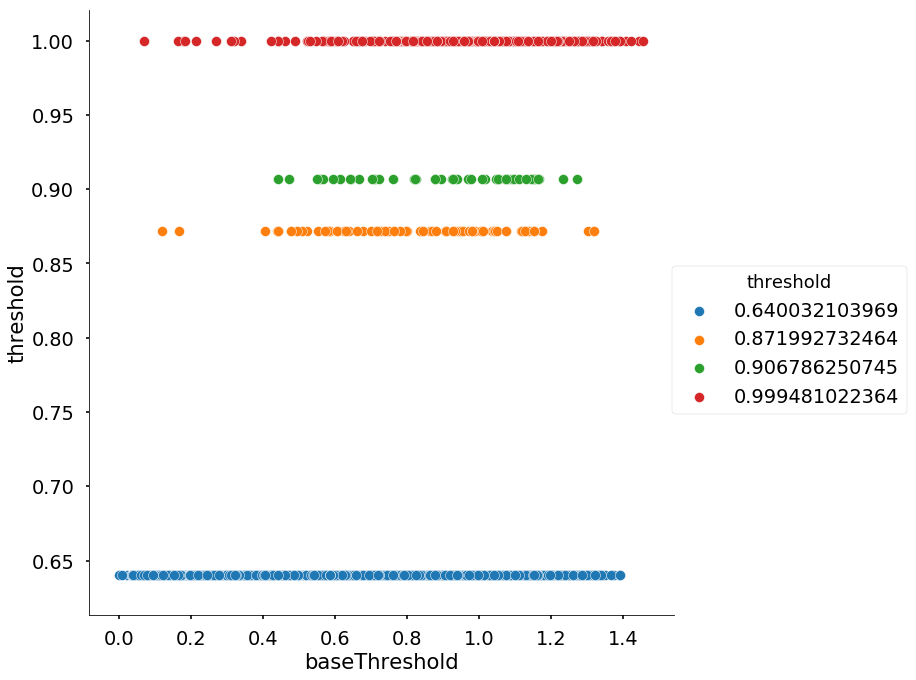

In [30]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['threshold'],data=cep, hue='threshold',
             size=10,plot_kws={'s':100})

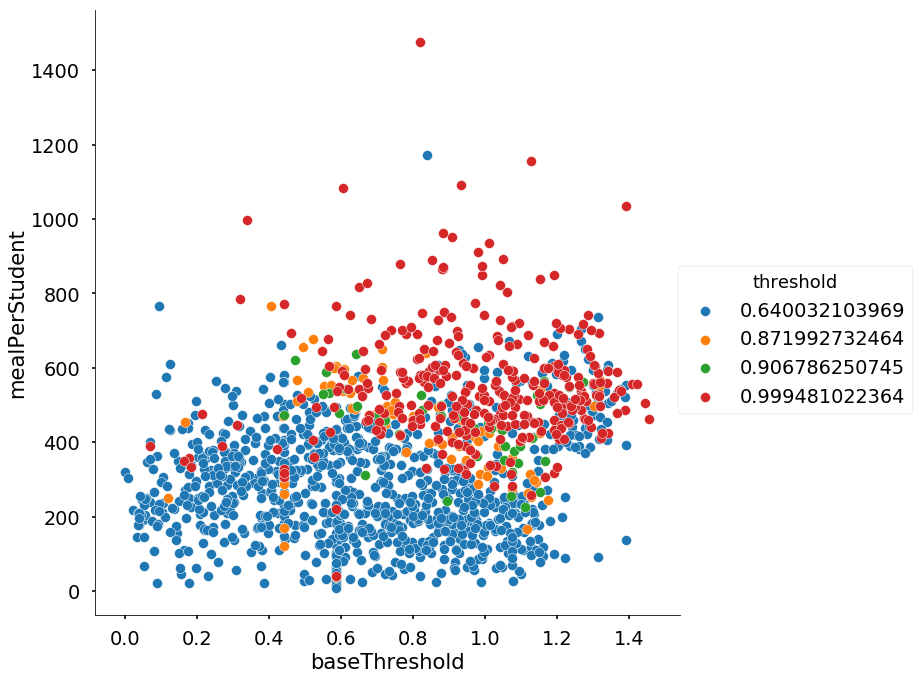

In [32]:
sns.pairplot(x_vars=['baseThreshold'],y_vars=['mealPerStudent'],data=cep, hue='threshold',
             size=10,plot_kws={'s':100})

In [31]:
pd.concat([cep.groupby('threshold').count()[['School']],
           cep.groupby('threshold').sum()[['Enrollment']],
           cep.groupby('threshold').mean()[['mealPerStudent']]],axis=1)

,School,Enrollment,mealPerStudent
threshold,,,
0.640032,989,535124.043632,279.727562
0.871993,81,32520.234662,435.046746
0.906786,44,19392.080952,444.656583
0.999481,339,139477.606755,552.447231
